dt is between 0.0197 and 0.0199 days

# Make Subdata

In [170]:
import pandas as pd
import numpy as np
import os
import re

was_cut = []
rows = []
days = []
mags = []

np.seterr(invalid='ignore')
directory_path = 'C:/Users/mikel/Desktop/Supernovae/CURVEPOPS/CURVEPOPS2-14-7-2025/snec-data'
for entry in os.listdir(directory_path):
    parts = re.findall(r'--\d+(?:\.\d+)?|[^-]+', entry)
    parts = [x if not x.startswith('--') else x[1:] for x in parts[3:]]

    mags_path = os.path.join(directory_path, entry, 'data/lum_observed.dat')
    info_path = os.path.join(directory_path, entry, 'data/info.dat')
    if os.path.isfile(mags_path):
        # Read mags
        df = pd.read_csv(mags_path, sep=' ', skipinitialspace=True, header=None, names=None)
        df.drop(index=0, inplace=True)
        t = df[0].values / 86400
        m = np.log10(df[1].values)
        mask = ~(np.isnan(m) | np.isinf(m))
        t = t[mask]
        m = m[mask]
        if len(m) > 10:
            rows.append(parts)
            days.append(t)
            mags.append(m)
            if np.sum(~mask) == 0:
                was_cut.append(False)
            else:
                was_cut.append(True)
        
        # Read mass
        df = pd.read_csv(info_path, sep='=', skipinitialspace=True, header=None)
        mass = re.findall(r'\d+\.?\d*', df[1][0])[0]
        parts[0] = mass
np.seterr(invalid='warn')

was_cut = np.array(was_cut)
days = pd.Series(days)
mags = pd.Series(mags)
df = pd.DataFrame(rows, columns=['M_ZAMS', 'E_exp', 'Ni_log', 'Ni_mix'])
mix = df['Ni_mix']
mix[mix == 'low'] = 0.1
mix[mix == 'mid'] = 0.5
mix[mix == 'max'] = 0.9

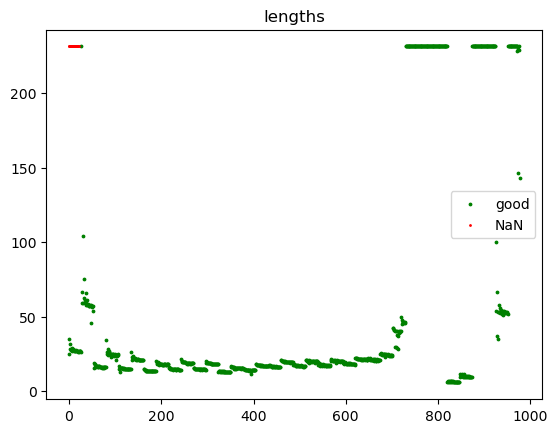

In [171]:
import matplotlib.pyplot as plt

lengths = []
for i in range(len(days)):
    t = days[i]
    lengths.append(t[len(t) - 1] - t[0])
lengths = np.array(lengths)

# Plot lengths and cut status
y = lengths[~was_cut]
plt.scatter(range(0, len(y)), y, s=3, c='green', label='good')
y = lengths[was_cut]
plt.scatter(range(0, len(y)), y, s=1, c='red', label='NaN')
plt.title('lengths')
plt.legend()
plt.show()

# Analyze the better sample
mask = (lengths < 30) & (lengths > 12)


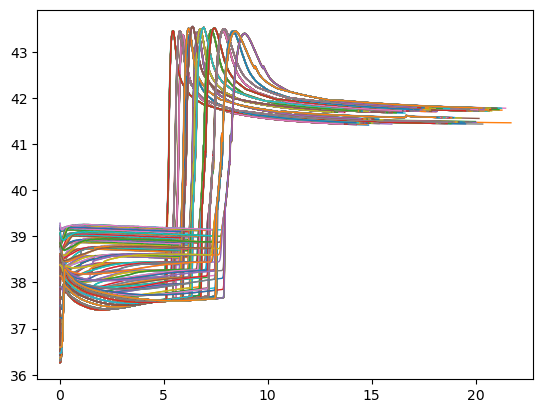

In [172]:
# Plot subset
mask_t = (df['M_ZAMS'].to_numpy(float) > 12) & (df['M_ZAMS'].to_numpy(float) < 17)
days_t = days[mask_t].reset_index(drop=True)
mags_t = mags[mask_t].reset_index(drop=True)
for i in range(len(days_t)):
    plt.plot(days_t[i], mags_t[i], lw=1)
plt.show()

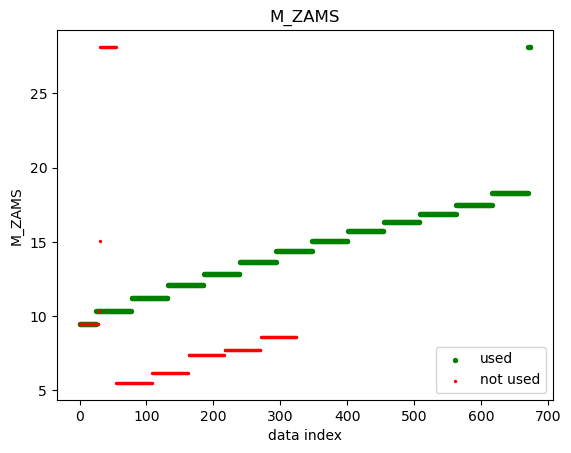

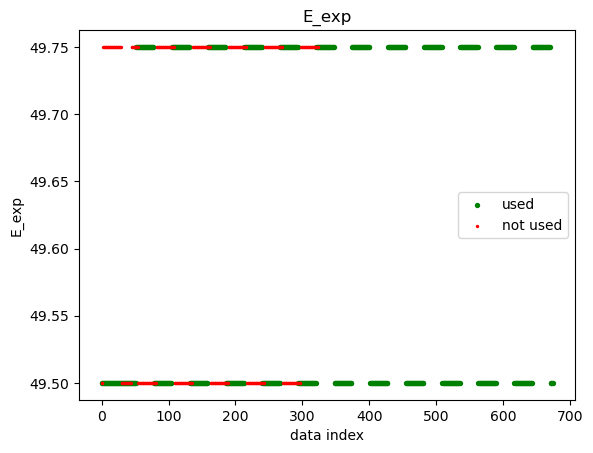

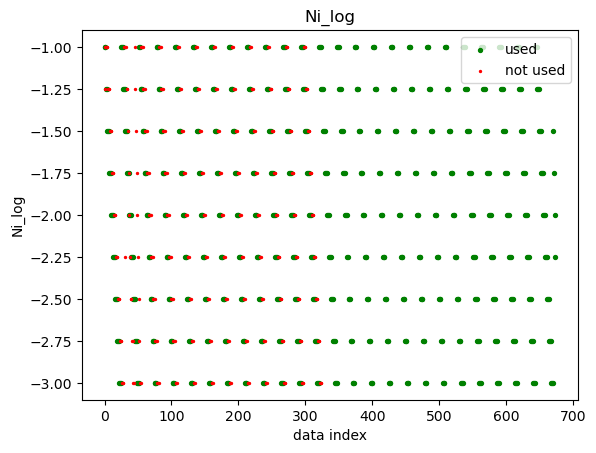

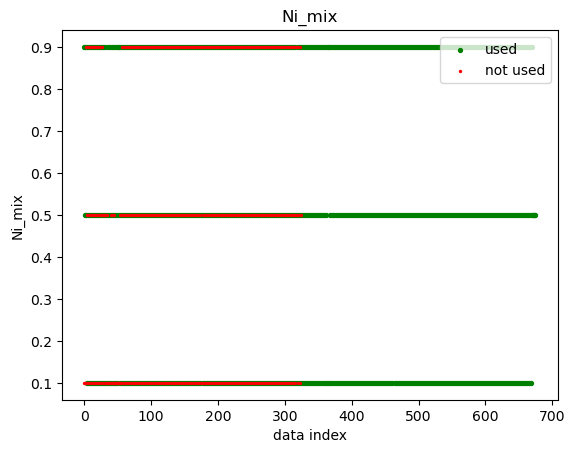

In [173]:
# Plot data that isn't being used
for name in df.columns:
    y = df[mask][name].astype(float)
    plt.scatter(range(0, len(y)), y, s=8, c='green', label='used')
    y = df[~mask][name].astype(float)
    plt.scatter(range(0, len(y)), y, s=2, c='red', label='not used')
    plt.xlabel('data index')
    plt.ylabel(name)
    plt.title(name)
    plt.legend()
    plt.show()

In [174]:
# Update data
lengths = lengths[mask]
days = days[mask].reset_index(drop=True)
mags = mags[mask].reset_index(drop=True)
df = df[mask].reset_index(drop=True)

# Remove outliers
lengths = lengths[:-4]
days = days[:-4]
mags = mags[:-4]
df = df[:-4]

# View Subdata

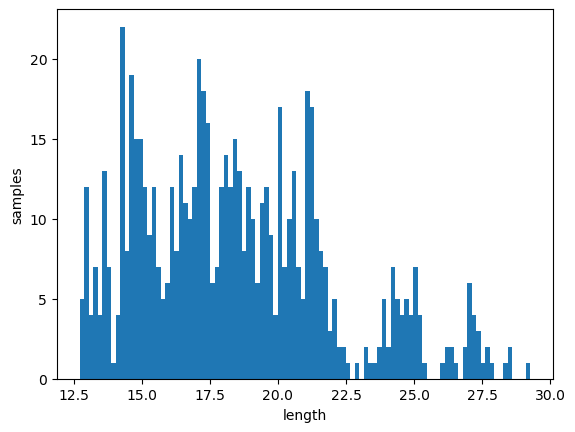

In [175]:
# Plot new sample
plt.hist(lengths, 100)
plt.xlabel('length')
plt.ylabel('samples')
plt.show()

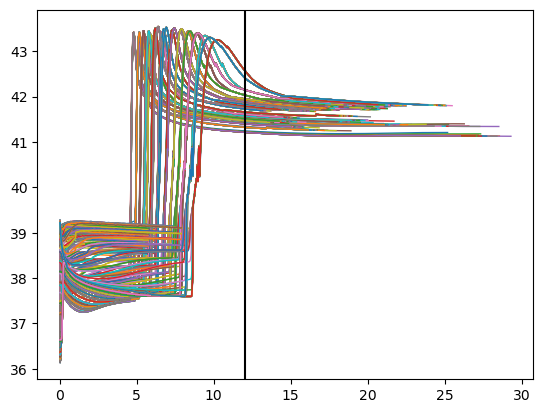

In [176]:
# Plot all curves, shows that data beyond 12 days is largely flat
for i in range(len(days)):
    plt.plot(days[i], mags[i], lw=1)
plt.axvline(12, c='black')
plt.show()

# Fit Models

In [177]:
# Take the min length days array and interpolate all magnitudes onto this range
from scipy.interpolate import interp1d

t = days[np.argmin(lengths)]
X = df
y = []
for i in range(len(mags)):
    interp = interp1d(days[i], mags[i], fill_value="extrapolate")
    y.append(interp(t))
y = np.array(y)

# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42)

# Linear interpolator
from scipy.interpolate import LinearNDInterpolator
interp = LinearNDInterpolator(X_train, y_train)

In [178]:
# Find hyperparameters
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

if False:
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('mlp', MLPRegressor(
            max_iter=10000, activation='relu', alpha=1e-3, learning_rate_init=1e-2, random_state=0, early_stopping=False,
        ))
    ])

    s = 450 # 2/3 of data, training size
    param_grid = {
        'mlp__hidden_layer_sizes': [(200, 100, 50, 25, 12), (200, 100, 50, 25)],
        #'mlp__activation': ['relu', 'tanh'],
        #'mlp__alpha': [1e-5, 1e-4, 1e-3],
        #'mlp__learning_rate_init': [1e-3, 1e-2]
    }

    search = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    search.fit(X, y)
    best_model = search.best_estimator_

    results = pd.DataFrame(search.cv_results_).sort_values('rank_test_score')
    print(results[['param_mlp__hidden_layer_sizes', 'std_test_score']])

    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print("Test MSE:", mse)
    print(search.best_params_)

# Results (MSE):
# (200, 100, 50, 25, 12): 1.602306
# (200, 100, 50, 25): 2.695390
# (200, 100): 9.710000


In [179]:
# MLPRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

mlp = MLPRegressor(
    max_iter=10000, activation='relu', alpha=1e-3, learning_rate_init=1e-2, hidden_layer_sizes=(200, 100)#, early_stopping=True
)
model = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', mlp)
])
model.fit(X_train, y_train)
#print(mlp.best_validation_score_)

# y_pred = model.predict(X_test)
# mse = mean_squared_error(y_test, y_pred)
# print("Test MSE:", mse)

Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp',
                 MLPRegressor(alpha=0.001, hidden_layer_sizes=(200, 100),
                              learning_rate_init=0.01, max_iter=10000))])

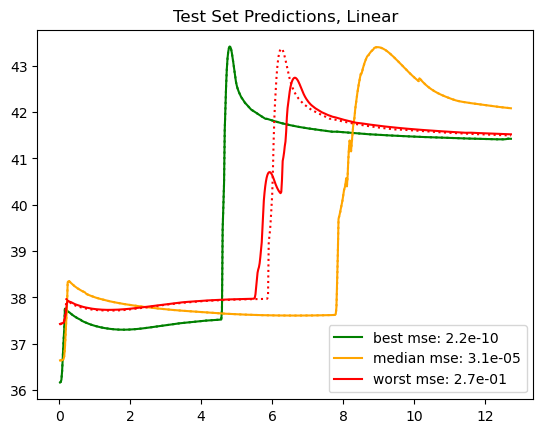

mean mse: 2.1e-02


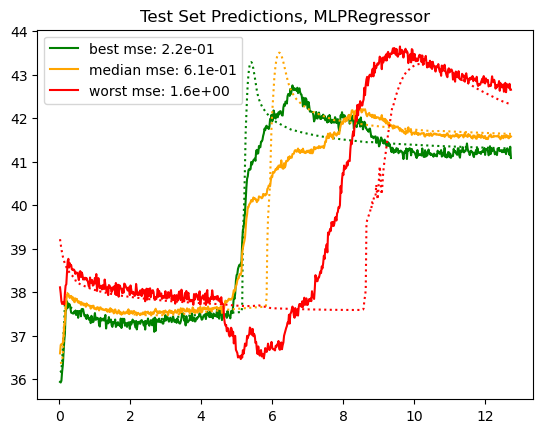

mean mse: 6.6e-01


In [180]:
def evaluate_predictions(y_test, y_pred, x_axis, title):
    mse = []
    tests = []
    preds = []

    # Filter out predictions that contain NaN values
    for i in range(len(y_test)):
        y_t = y_test[i]
        y_p = y_pred[i]
        if np.isnan(y_p).sum() == 0:
            mse.append(mean_squared_error(y_t, y_p))
            tests.append(y_t)
            preds.append(y_p)

    # Sort by mse
    total = len(mse)
    sorted_indices = np.argsort(mse)
    min_i = sorted_indices[0]
    med_i = sorted_indices[total // 2]
    max_i = sorted_indices[total - 1]

    # Plot best, median, and worst predictions
    plt.plot(x_axis, preds[min_i], c='green', label='best mse: ' + f'{mse[min_i]:.1e}')
    plt.plot(x_axis, tests[min_i], c='green', ls=':')
    plt.plot(x_axis, preds[med_i], c='orange', label='median mse: ' + f'{mse[med_i]:.1e}')
    plt.plot(x_axis, tests[med_i], c='orange', ls=':')
    plt.plot(x_axis, preds[max_i], c='red', label='worst mse: ' + f'{mse[max_i]:.1e}')
    plt.plot(x_axis, tests[max_i], c='red', ls=':')
    plt.title(title)
    plt.legend()
    plt.show()
    
    print('mean mse: ' + f'{np.mean(mse):.1e}')

evaluate_predictions(y_test, interp(X_test), t, 'Test Set Predictions, Linear')
evaluate_predictions(y_test, model.predict(X_test), t, 'Test Set Predictions, MLPRegressor')

# Fit Observed

n: 18


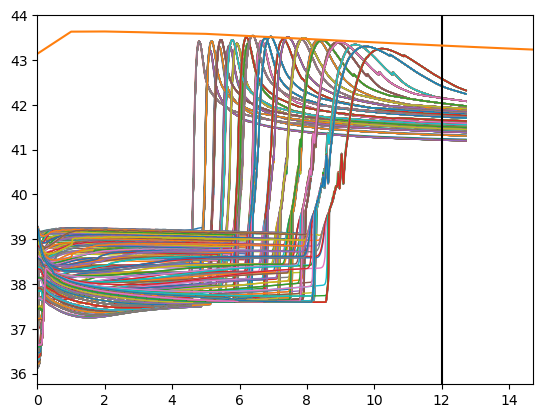

In [ ]:
# Get observational data
compare_path = 'C:/Users/mikel/Desktop/Supernovae/CURVEPOPS/2020hgw.dat_0.txt'
data = pd.read_csv(compare_path, sep=' ')
t_obs = data['Time (MJD)']
t_obs -= np.min(t_obs)
m_obs = data['Log10(Bol. Lum)']

# Number of measurements within relevant time
mask = t_obs < (max(t) + 5)
print('n:', len(t_obs[mask]))

# Plot all curves
for i in range(len(y)):
    plt.plot(t, y[i], lw=1)
plt.axvline(12, c='black')
plt.plot(t_obs, m_obs)
plt.xlim(0, max(t) + 2)
plt.show()

In [182]:
# Find best parameters
from util import find_dx
results = []

def f(x):
    M_ZAMS, E_exp, Ni_log, Ni_mix = x
    X_mod = {'M_ZAMS': M_ZAMS, 'E_exp': E_exp, 'Ni_log': Ni_log, 'Ni_mix': Ni_mix}
    t_mod = t
    m_mod = interp(list(X_mod.values()))[0]
    #m_mod = model.predict(pd.DataFrame([X_mod]))[0]
    dt, mse = find_dx(t_mod, m_mod, t_obs, m_obs, (0, 10))
    results.append({'mse': mse, 'dt': dt, 'X': X_mod, 'm': m_mod})
    return mse

from scipy.optimize import minimize
result = minimize(f, x0=[15, 49.65, -1.375, 0.1], bounds=[(9, 20), (49, 50), (-3.5, -0.5), (0, 1)])
results = sorted(results, key=lambda x: x['mse'])


c:\Users\mikel\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


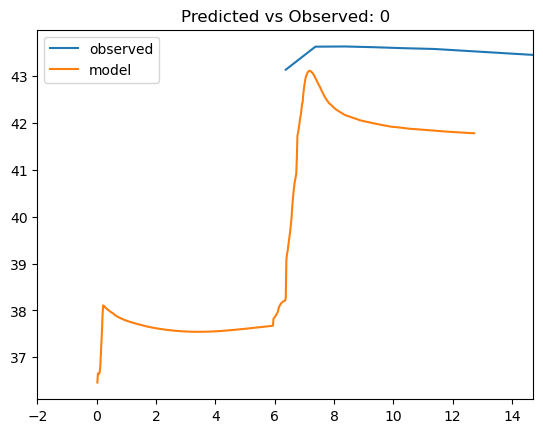

mse: 1.4639800918981578
dt: 6.374999146686625
X: {'M_ZAMS': 15.0, 'E_exp': 49.65000001, 'Ni_log': -1.375, 'Ni_mix': 0.1}


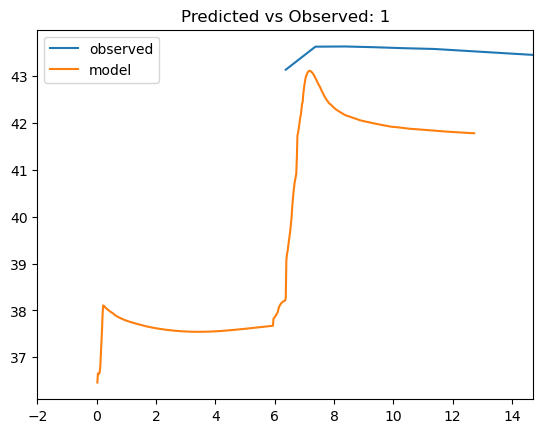

mse: 1.4639800918981578
dt: 6.374999146686625
X: {'M_ZAMS': 15.0, 'E_exp': 49.65000001, 'Ni_log': -1.375, 'Ni_mix': 0.1}


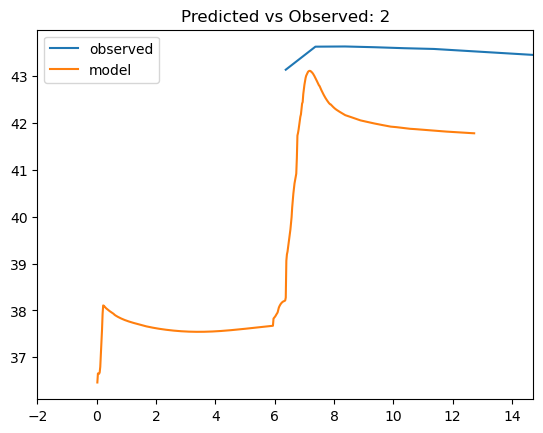

mse: 1.4639801086313402
dt: 6.374999146686625
X: {'M_ZAMS': 15.0, 'E_exp': 49.65, 'Ni_log': -1.375, 'Ni_mix': 0.10000001}


In [184]:
for i in range(3):
    t_mod = t
    m_mod = results[i]['m']
    dt = results[i]['dt']

    mask = (t_obs < max(t_mod)) & (t_obs > min(t_mod))
    # plt.plot(t_obs, m_obs - np.mean(m_obs[mask]) + np.mean(m_mod), label='observed')
    plt.plot(t_obs + dt, m_obs, label='observed')
    plt.plot(t_mod, m_mod, label='model')
    plt.xlim(-2, max(t_mod) + 2)
    plt.title('Predicted vs Observed: ' + str(i))
    plt.legend()
    plt.show()

    print('mse:', results[i]['mse'])
    print('dt:', dt)
    print('X:', results[i]['X'])